<a href="https://colab.research.google.com/github/platycristate/AnalysisOfMuscleContraction/blob/master/denaturation/denaturation_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Кислотна денатурація білків

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import re
import os
import peakutils
from BaselineRemoval import BaselineRemoval
plt.style.use('seaborn-whitegrid')

## Зчитування данних

In [2]:
data_dir = 'data'
files = os.listdir(data_dir)

# обираємо тільки файли з роширенням .txt
files = [file for file in files if file.endswith('.txt')]
files.remove('normal.txt')

# створюємо пустий датафрейм з колонками для кожного файлу + одна колонка буде довжинами хвиль
files = [data_dir + '/' + file for file in files]
spect = pd.DataFrame()

# зчитуємо довжини хвиль
f1 = pd.read_csv(files[0], sep='  ', engine='python')
f2 = pd.read_csv(data_dir + '/normal.txt', sep='  ', engine='python')
spect['lambda, nm'] = f1.iloc[:,0]
spect['control'] =  f2.iloc[:,1]

time = []
for idx, path in enumerate(files):
    p = re.compile(r'_\d*m')
    dur = p.search(path).group(0)[1:-1]
    time.append( int(dur) )
    f = pd.read_csv(path, sep='  ', engine='python')
    spect[int(dur)] = f.iloc[:,1]
time = sorted(time)

# виріжемо частину графіку в області далекого ультрафіолету
idx = spect.loc[spect['lambda, nm'] == 230].index[0]
spect = spect.iloc[:idx, :]

## Тепер знайдемо базові лінії і віднімемо їх

In [73]:
spect_align = spect[['lambda, nm','control', 20, 30, 60]]
baseline = {}
for col in spect_align.columns[1:]:
    absor_align = BaselineRemoval(np.array(spect_align[col])).ZhangFit(itermax=10**3)
    baseline[col] = np.array(spect_align[col]) - absor_align
    spect_align[col] -= baseline[col]

WARING max iteration reached!


## Зображуємо спектри поглинання для різного часу денатурації
### 1. Без віднімання базової лінії

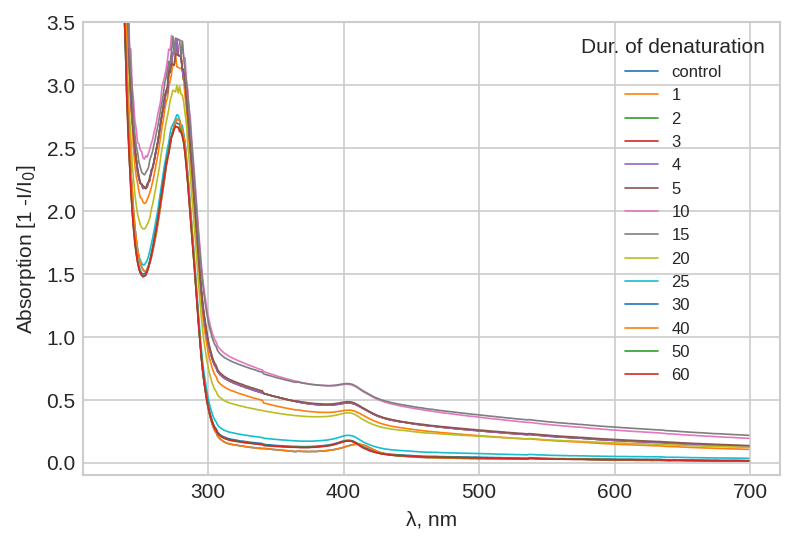

In [74]:
plt.figure(dpi=150);
plt.plot(spect['lambda, nm'], spect['control'], lw=0.8, label='control')
for i in time:
    plt.plot(spect['lambda, nm'], spect[i], lw=0.8, label=i)
plt.legend(title='Dur. of denaturation', fontsize=8);
plt.xlabel('λ, nm');
#plt.xlim(220, )
plt.ylim(-0.1, 3.5)
plt.ylabel('Absorption [1 -I/I$_0$]');

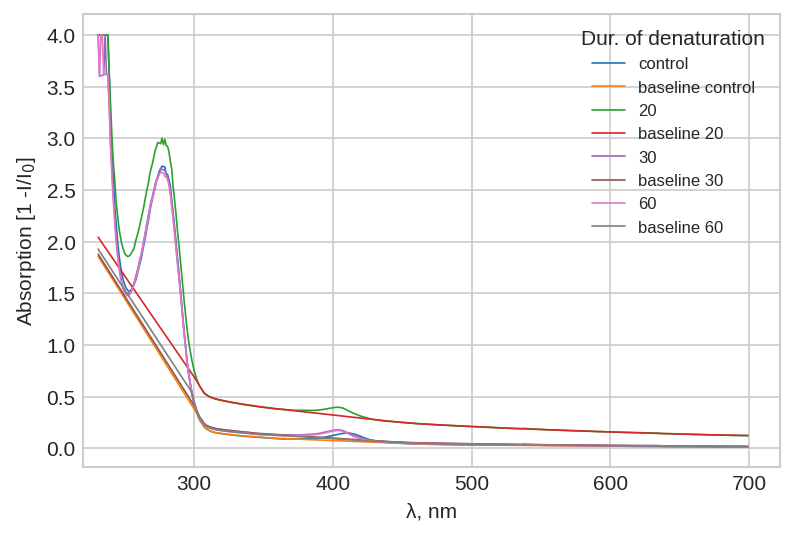

In [75]:
plt.figure(dpi=150);
for i in spect_align.columns[1:]:
    plt.plot(spect['lambda, nm'], spect[i], lw=0.8, label=i)
    plt.plot(spect['lambda, nm'], baseline[i], lw=0.8, label='baseline '+str(i))
plt.legend(title='Dur. of denaturation', fontsize=8);
plt.xlabel('λ, nm');
plt.xlim(220, )
#plt.ylim(-0.1, 3.5)
plt.ylabel('Absorption [1 -I/I$_0$]');

### 2. З відніманнням базової лінії

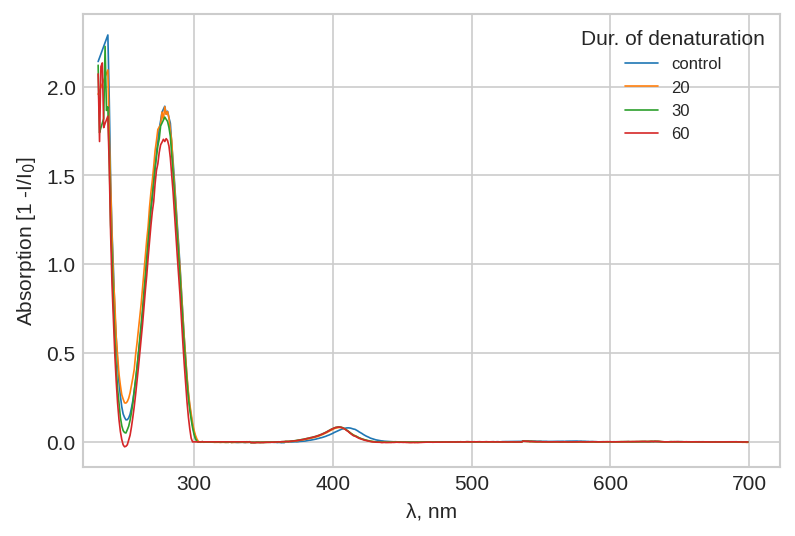

In [76]:
plt.figure(dpi=150);
for i in spect_align.columns[1:]:
    plt.plot(spect['lambda, nm'], spect_align[i], lw=0.8, label=i)
plt.legend(title='Dur. of denaturation', fontsize=8);
plt.xlabel('λ, nm');
plt.xlim(220, )
#plt.ylim(-0.1, 3.5)
plt.ylabel('Absorption [1 -I/I$_0$]');

На вищенаведеному графіку видно, що під час денатуації спостерігалося загальне зменшення поглинання. Як це можна пояснити? Коли відбувається денатурація, то білки втрачають
свою третинну структуру і розгортаються, гідрофобні частини, які були раніше всередені глобули, тепер назовні. Для того, щоб "зменшити ентропію" розгорнуті білки починають
формувати агрегати. Таким чином, загальна кількість частинок зменшується і зменшується поглинання (якщо в рамках закону Ламберта-Бера). 

Також на 400 нм можна бачити пік, який скоріш за все пов'язаний з гемоглобіном, який залишився в сироватці крові. Можна помітити, що для нього спостерігається невеликий зсув
в сторону менших довжин хвиль (більшої енергії) -- так званий "синій зсув". Пов'язано це з тим, що амінокислоти, які раніше були у відносно гідрофобному середовищі, потрапили тепер у гідрофільне середовище. Тому якась частина поглинутої енергії витрачається на взаємодію з гідрофільними речовинами (скоріш за все з водою). 

Ще з цікавого можна побачити невеликі за амплітудую коливання на вершині піку (~275 нм). Ці коливання пов'язані з тим, що електрони знаходяться на різних теплових модах енергетичного рівня. Якщо електрон **вже** знаходиться на вищій тепловій моді, то потрібно менше енергії, щоб перевести його на наступний енергетичний рівень і навпаки для нижчої теплової моди. Саме тому, ми спостерігаємо такі невеликі коливання. Енергія хвилі залежить від довжини, 
а от амплітуда поглинання вже залежить від імовірності переходу, яка також залежить від кількості електронів, які знаходяться на певному коливальному рівні (теплова мода).

## Знаходимо другу похідну
Завдяки аналізу другої похідної спектру, ми можемо краще побачити, де саме спостерігаються зміни теплових мод. Для точок мінімумів на спектрі будуть відповідати максимуми
на графіку другої похідної і навпаки для точок максимумів на спектрі. Саме ці різкі зміни в другій похідній говорять про теплові моди. Один максимум + мінімум після нього в графіку другої похідної може нам говорити про наявність однієї теплової моди.

In [6]:
def second_der(x, y):
    x = np.array(x)
    y = np.array(y)
    
    dy = np.diff(y,1)
    dx = np.diff(x,1)

    yfirst = dy/dx
    xfirst = 0.5*(x[:-1]+x[1:])

    dyfirst = np.diff(yfirst,1)
    dxfirst = np.diff(xfirst,1)

    ysecond = dyfirst/dxfirst
    xsecond = 0.5*(xfirst[:-1]+xfirst[1:])
    
    return [xsecond, ysecond]

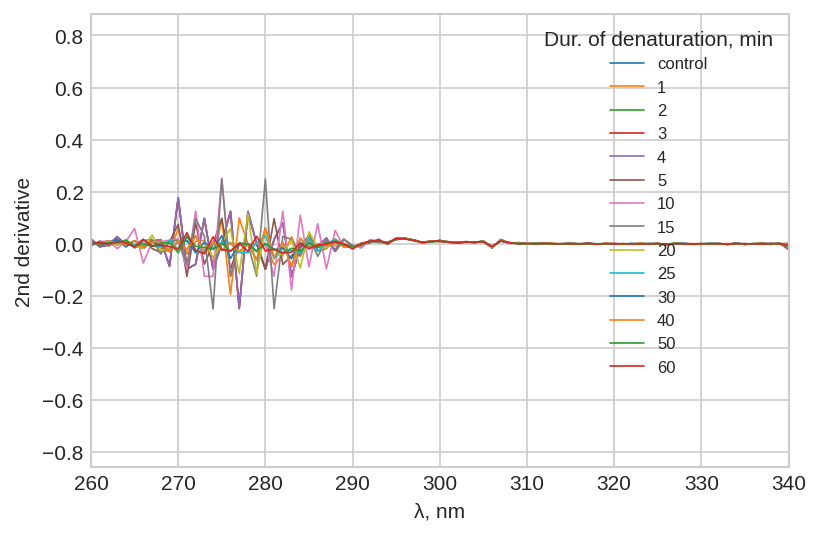

In [7]:
der = second_der(spect['lambda, nm'], spect['control'])

plt.figure(dpi=150)
plt.plot(der[0], der[1], lw=0.8, label='control')
for i in time:
    der = second_der(spect['lambda, nm'],spect[i])
    plt.plot(der[0], der[1], lw=0.8, label=i)
    plt.legend(title='Dur. of denaturation, min', fontsize=8, loc='upper right');
    plt.xlabel('λ, nm');
    plt.xlim(260, 340)
    plt.ylabel('2nd derivative');

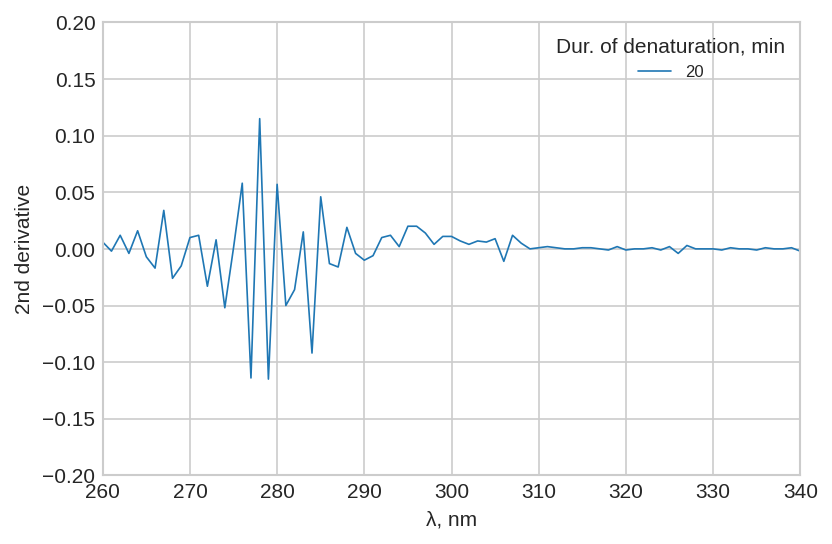

In [118]:
der = second_der(spect['lambda, nm'],spect[20])
plt.figure(dpi=150)
plt.plot(der[0], der[1], lw=0.8, label=20)
plt.legend(title='Dur. of denaturation, min', fontsize=8, loc='upper right');
plt.xlabel('λ, nm');
plt.xlim(260, 340)
plt.ylim(-0.2, 0.2)
plt.ylabel('2nd derivative');

## Базове розсіювання світла
Виділяємо значення поглинання на 330 нм і будуємо графік, де по осі OX - час (хв), по осі OY - поглинання на 330 нм. Даний графік продемонструє як
змінювалося базове розсіювання світла при денатурації. Це розсіювання світла не буде специфічним, тому що в сироватці крові на 330 нм ніщо специфічно не поглинає. **Базову лінію варто залишити, так як в саме там міститься багато неспецифічного поглинання**

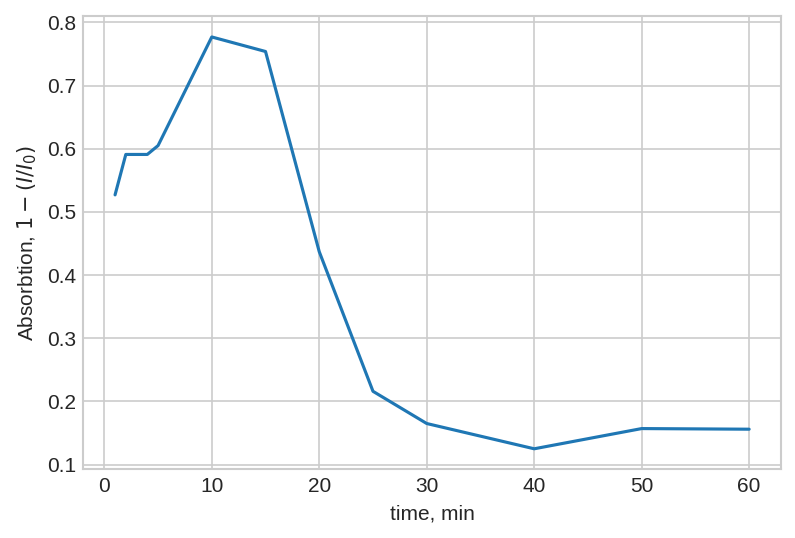

In [8]:
row =  spect.loc[ spect['lambda, nm'] == 330 ].iloc[:,2:]
t_absor = {t:v for t, v in zip(row.columns, row.squeeze())}
t_absor = sorted(t_absor.items(), key=lambda x: x[0])
time, absor = [x[0] for x in t_absor], [x[1] for x in t_absor]
plt.figure(dpi=150)
plt.plot(time, absor)
plt.ylabel('Absorbtion, $1 - (I/I_0)$');
plt.xlabel('time, min');

Видно що на початку денатурації воно дещо підвищилося: білки денатурували, але ще не встигли агрегувати, денатуровані білки збільшили простір, який вони займають і за рахунок
цього почали розсіювати більше світла. Після цього вже відбулася агрегація денатурованого білка, і тому зменшився загальний об'єм, який займають білки і це призвело до 
зменшення розсіювання світла.

## Фітування функцій Гауса до піків

In [9]:
from scipy.optimize import curve_fit
import random

[  1.55336765   0.58587023   0.60635252 277.74024372 287.14222209
 265.98562936   6.79566153   4.94439309   5.64514621]


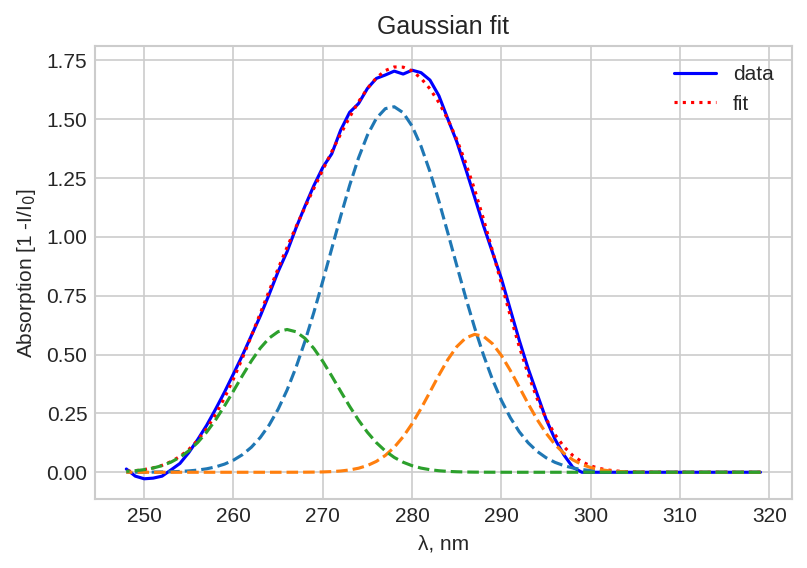

In [112]:
x = np.array(spect['lambda, nm'][380:452])
y = np.array(spect_align[60][380:452])


mean = sum(x * y) / sum(y)
sigma = np.sqrt(sum(y * (x - mean)**2) / sum(y))

def Gauss(x, a1, a2, a3, x01, x02, x03, sigma1, sigma2, sigma3):
    aa1 = a1 * np.exp(-(x - x01)**2 / (2 * sigma1**2))
    aa2 = a2 * np.exp(-(x - x02)**2 / (2 * sigma2**2))
    aa3 = a3 * np.exp(-(x - x03)**2 / (2 * sigma3**2))
    return aa1 + aa2 + aa3

def Gauss_single(x, a, x0, sigma):
    return a * np.exp(-(x - x0)**2 / (2 * sigma**2))

popt,pcov = curve_fit(Gauss, x, y, 
                      p0=[*np.random.random(3), *[random.choice(x) for i in range(3)], 
                          *np.random.random(3)], 
                      bounds=(0, np.inf))
print(popt)
plt.figure(dpi=150)
plt.plot(x, y, 'b', label='data')
plt.plot(x, Gauss(x, *popt), 'r--', label='fit', linestyle='dotted')
plt.plot(x, Gauss_single(x, popt[0], popt[3], popt[6]), '--')
plt.plot(x, Gauss_single(x, popt[1], popt[4], popt[7]), '--')
plt.plot(x, Gauss_single(x, popt[2], popt[5], popt[8]), '--')
plt.legend()
plt.title('Gaussian fit')
plt.xlabel('λ, nm')
plt.ylabel('Absorption [1 -I/I$_0$]')
plt.show()

Як можна бачити, результат оптимізації параметрів функцій Гауса (за допомогою методу найменших квадратів) для фітування піку говорить нам про те, що пік в нашому спектрі описується
лінійною комбінацією поглинання трьох амінокислот (фенілаланіну, тирозину та триптофану). 